In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import scipy.stats as st
from sklearn.decomposition import PCA
from lmfit import minimize, Parameters
from tqdm.notebook import tqdm

mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["pdf.fonttype"] = 42
sns.set_style(
    "ticks",
    {
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "font_color": "k",
        "axes.edgecolor": "k",
        "xtick.color": "k",
        "ytick.color": "k",
    },
)
sns.set_context("talk", font_scale=1.0)

act_rep_palette = ["tab:blue", "tab:orange", "tab:olive"]

d2_threshold = 0.639
d5_threshold = 0.103

d2_baseline_threshold = -0.938
d5_baseline_threshold = -0.300

# Importing data

In [4]:
df = pd.read_csv("../01_activators_synergy/pairs_baselinesums.csv")
df

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d2_description,d2_baseline_type,d2_prior_type,composition,character,ptype,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,Repressor,Non-hit,Repressor,D-N,Other,Effector Pair,True,True,1.126839,2.456298
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,Repressor,Dual,Repressor,D-D,Other,Effector Pair,True,True,5.959180,0.706417
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,Repressor,Repressor,Repressor,R-R,Repressor,Effector Pair,False,True,-3.901673,-1.582110
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,Activator,Dual,Activator,D-D,Other,Effector Pair,True,True,5.391484,1.549693
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,Repressor,Non-hit,Repressor,R-N,Other,Effector Pair,False,True,-3.468438,-1.231666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,Random_control;;;21; --- Silencer_tiles;ENSG00...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Repressor,Repressor,Repressor,C-R,Repressor,Effector Pair,NaN,NaN,-3.146319,-2.564413
8335,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Repressor,Repressor,Repressor,C-R,Repressor,Effector Pair,NaN,NaN,-3.969341,-1.808862
8336,Random_control;;;21; --- Short_nuclear_domain;...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Repressor,Repressor,Repressor,C-R,Repressor,Effector Pair,NaN,NaN,-3.913868,-2.759884
8337,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Activator,Non-hit,Activator,C-N,Other,Effector Pair,NaN,NaN,-2.354220,3.120483


In [5]:
oligos = pd.read_csv("../../fig_1/01_raw_counts/csvs/base_oligo_library.csv")
oligos

,Unnamed: 0,Gene,label,Pathway,Description,Extended Domain DNA sequence
0,0,CBX1,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,HP1,NucDom Repr,GAGGAGAGCGAGAAGCCCAGAGGCTTCGCCAGAGGCCTGGAGCCCG...
1,1,SUMO3,Short_nuclear_domain;SUMO3_HUMAN;Rad60-SLD;12;70,Sumoylation,NucDom Repr,GAGAACGACCACATCAACCTGAAGGTGGCCGGCCAGGACGGCAGCG...
2,2,CDYL2,Short_nuclear_domain;CDYL2_HUMAN;Chromo;1;50,Chromodomain,NucDom Repr,GCCAGCGGCGACCTGTACGAGGTGGAGAGAATCGTGGACAAGAGAA...
3,3,MPP8,Short_nuclear_domain;MPP8_HUMAN;Chromo;44;50,Binds H3K9me3; HUSH complex/SETDB1,NucDom Repr,GCCGAGGCCTTCGGCGACAGCGAGGAGGACGGCGAGGACGTGTTCG...
4,4,YAF2,Short_nuclear_domain;YAF2_HUMAN;YAF2_RYBP;78;32,"Yy1, PcG; inhibits Myc, H3K9me3",NucDom Repr,AAGGACAAGGTGGAGAAGGAGAAGAGCGAGAAGGAGACCACCAGCA...
...,...,...,...,...,...,...
95,95,ZIK1,Human_KRAB_variant;M0QYP0;367,HP1 (KRAB),KRAB Repr,AGAGCCCCCACCCAGGTGACCGTGAGCCCCGAGACCCACATGGACC...
96,96,ZNF10,Human_KRAB_variant;P21506;146,HP1 (KRAB),KRAB Repr,GACGCCAAGAGCCTGACCGCCTGGAGCAGAACCCTGGTGACCTTCA...
97,97,ZNF791,Human_KRAB_variant;Q3KP31;676,HP1 (KRAB),KRAB Repr,GTGGCGTTTGAAGATGTGAGCGTGAGCTTTAGCCAGGAAGAATGGG...
98,98,ZNF496_K,NIZP1_KRAB,Unknown,KRAB Activator,CAGGAGGAGAACGTGAGAGACACCCAGCAGGTGACCACCCTGCAGC...


In [6]:
baselines = pd.read_csv("../../fig_1/03_computing_baselines/baseline_scores.csv")
baselines

,domain,avg_d2,med_d2,sd_d2,min_d2,max_d2,delta_min_d2,delta_max_d2,avg_d5,med_d5,...,rep_sd_d5,rep_min_d5,rep_max_d5,rep_delta_min_d5,rep_delta_max_d5,is_activator,is_repressor,baseline_type,prior_type,gene
0,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,-2.723895,-2.796018,0.688257,-3.899350,-1.152775,1.103332,2.746575,-2.581530,-2.642873,...,0.642879,-3.796554,-1.440654,1.046026,2.355901,False,True,Repressor,Repressor,NaN
1,Short_nuclear_domain;SUMO3_HUMAN;Rad60-SLD;12;70,-2.559898,-2.672776,0.499699,-3.213500,-1.414590,0.540724,1.798910,-2.594383,-2.608911,...,0.912386,-4.673955,-0.704240,2.049007,3.969714,False,True,Repressor,Repressor,NaN
2,Short_nuclear_domain;CDYL2_HUMAN;Chromo;1;50,-2.537211,-2.326746,0.790697,-3.818794,-0.558255,1.492047,3.260539,-2.876315,-3.294145,...,0.825153,-4.160111,-0.947768,0.809262,3.212343,False,True,Repressor,Repressor,NaN
3,Short_nuclear_domain;MPP8_HUMAN;Chromo;44;50,-2.639417,-2.695604,0.448160,-3.269960,-1.850474,0.574355,1.419486,-2.251854,-2.699218,...,1.093412,-3.946956,-0.696035,1.124470,3.250921,False,True,Repressor,Repressor,NaN
4,Short_nuclear_domain;YAF2_HUMAN;YAF2_RYBP;78;32,-1.868021,-2.050970,0.917464,-2.977203,0.840593,0.926233,3.817796,-2.509226,-2.996155,...,1.124003,-4.032861,-0.533026,0.984842,3.499835,False,True,Repressor,Repressor,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Human_KRAB_variant;M0QYP0;367,-2.102769,-2.196488,0.441957,-2.818248,-1.247801,0.621761,1.570447,-2.847535,-2.908214,...,0.650209,-4.026562,-1.246139,1.118349,2.780423,False,True,Repressor,Repressor,NaN
96,Human_KRAB_variant;P21506;146,-2.413179,-2.450984,0.402020,-3.239612,-1.567078,0.788628,1.672534,-3.271126,-3.120449,...,0.604558,-4.399841,-2.299187,1.279392,2.100655,False,True,Repressor,Repressor,NaN
97,Human_KRAB_variant;Q3KP31;676,-2.605614,-2.621597,0.577849,-3.799185,-1.591482,1.177588,2.207704,-3.094451,-3.007482,...,0.849541,-4.498503,-1.465494,1.491021,3.033008,False,True,Repressor,Repressor,NaN
98,NIZP1_KRAB,-0.714963,-0.644504,0.690303,-1.652541,1.305217,1.008038,2.957759,1.265219,1.235410,...,NaN,inf,-inf,NaN,-inf,False,NaN,Non-hit,Activator,NaN


# Define function to fit Hill equations to domains

In [12]:
def domain_hill_fit(gene, ax):

    # get dataframe of scores
    domain = list(oligos[oligos["Gene"] == gene]["label"])[0]
    smoldf = df[(df["domain1"] == domain) | (df["domain2"] == domain)]
    score = list(df[(df["domain1"]==domain)]["d1_med_d2"])[0]
    that_scores = np.where(
        smoldf["domain1"] == domain, smoldf["d2_med_d2"], smoldf["d1_med_d2"]
    )
    this_scores = np.where(
        smoldf["domain1"] == domain, smoldf["d2_med_d2"], smoldf["d1_med_d2"]
    )
    combo_scores = np.array(smoldf["avg_enrichment_d2"])
    anm2_df = pd.DataFrame.from_dict(
        {"domain": this_scores, "other": that_scores, "combo": combo_scores}
    )

    # fit a hill function
    nona_df = anm2_df.dropna()

    def hill(x, Kd, n, Vmin, Vmax):
        return ((x + 4) ** n / ((x + 4) ** n + (Kd + 4) ** n)) * (Vmax - Vmin) + Vmin

    def residual(params, x, data):
        Kd = params["Kd"]
        n = params["n"]
        Vmax = params["Vmax"]
        Vmin = params["Vmin"]
        model = hill(x, Kd, n, Vmin, Vmax)
        return data - model

    params = Parameters()
    params.add("Kd", min=-2, max=3)
    params.add("Vmin", min=-4.0, max=-1.0)
    params.add("Vmax", min=-1.0, max=4.0)
    params.add("n_penalty", min=-5.0, max=5.0)
    # 40 * 1/(1.0 * np.sqrt(6.28)) * np.exp(-0.5 * ((x - 4.5)/1.0)**2) + 2.5
    params.add("n", expr="n_penalty + 40 * 1/(1.0 + sqrt(6.28)) * exp(-0.5 * ((Vmax - Vmin - 4.5)/1.0)**2)")
    out = minimize(
        residual, params, args=(nona_df["other"], nona_df["combo"]), method="nelder"
    )

    # set up plot geometry
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-5.5, 5.5)

    # plot
    Kd = out.params["Kd"].value
    n = out.params["n"].value
    Vmin = out.params["Vmin"].value
    Vmax = out.params["Vmax"].value
    g = sns.scatterplot(data=nona_df, x="other", y="combo", ax=ax, marker=".")
    score_lo = score < 0
    title = gene 
    if score < 0:
        title = title + ", $-$" + "{:.2f}".format(np.abs(score))
    else:
        title = title + ", " + "{:.2f}".format(score)
    ax.set_title(title)
    ax.set_xlabel("Partner Act. $\log_2$(ON:OFF)")
    ax.set_ylabel("Combo Act.\n$\log_2$(ON:OFF)")
    x = np.linspace(-4, 4, 50)
    y = hill(x, Kd, n, Vmin, Vmax)
    ax.plot(x, y, color="tab:red")

    # draw Kd value
    Kd_point = hill(Kd, Kd, n, Vmin, Vmax)
    Kd_plot_coord = (Kd_point + 5.5) / 11
    # print(Kd_plot_coord)
    ax.axvline(Kd, ymax=Kd_plot_coord, color="#ff7f0e", linestyle="--", lw=2)
    ax.axhline(Kd_point, xmax=(Kd + 3.5) / 7.0, color="#ff7f0e", linestyle="--", lw=2)
    ax.scatter(Kd, Kd_point, marker="o", c="#ff7f0e", s=50)

    # return df
    return pd.DataFrame.from_dict(
        {
            "gene": [gene],
            "label": [domain],
            "Kd": [Kd],
            "n": [n],
            "Vmax": [Vmax],
            "Vmin": [Vmin],
        }
    )

,gene,label,Kd,n,Vmax,Vmin
0,ITCH,Short_nuclear_domain;ITCH_HUMAN;WW;302;29,-1.02335,7.220655,2.39137,-2.121951


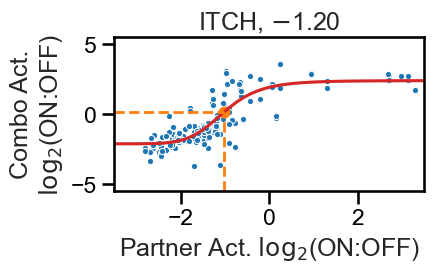

In [14]:
#Test with ANM2

fig, ax = plt.subplots(figsize = (4, 2))
domain_hill_fit("ITCH", ax)

In [15]:
activators = baselines[baselines["baseline_type"].isin(["Activator", "Dual"])]
activators = (
    activators.set_index("domain")
    .join(oligos.set_index("label"), how="left")
    .reset_index()
)

In [16]:
a_gene = list(activators["Gene"])

df_list = []

for g in tqdm(a_gene):
    fig, ax = plt.subplots(figsize = (4,2))
    df_list.append(domain_hill_fit(g, ax))
    sns.despine()
    fig.savefig('./01_fitplots/'+g+'.pdf', bbox_inches = 'tight')
    plt.close()
    
hilldf = pd.concat(df_list).reset_index()
hilldf

  0%|          | 0/17 [00:00<?, ?it/s]

,index,gene,label,Kd,n,Vmax,Vmin
0,0,ZN473,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41,-1.709375,13.955435,2.773886,-1.938470
1,0,FOXO3,Short_nuclear_domain;FOXO3_HUMAN;FOXO-TAD;584;41,-1.856147,15.199714,2.684367,-1.902806
2,0,MYBA,Short_nuclear_domain;MYBA_HUMAN;LMSTEN;223;46,-1.844768,16.296125,2.533741,-2.107298
3,0,NCOA2,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,-1.858109,10.755704,3.014618,-1.764244
4,0,SMCA2,Short_nuclear_domain;SMCA2_HUMAN;QLQ;150;34,-1.382911,10.066381,2.739891,-2.519471
5,0,KIBRA,Short_nuclear_domain;KIBRA_HUMAN;WW;1;29,-1.549060,9.644593,2.105909,-2.101679
6,0,ZN597,Short_nuclear_domain;ZN597_HUMAN;KRAB;1;41,-1.519733,3.462469,2.898009,-2.702232
7,0,APBB1,Short_nuclear_domain;APBB1_HUMAN;WW;229;28,-1.300899,7.211065,2.726037,-2.348215
8,0,ANM2,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,-1.294003,9.624619,3.689793,-2.154091
9,0,CRTC2,Short_nuclear_domain;CRTC2_HUMAN;TORC_C;613;77,-1.457458,9.127374,2.857396,-2.350899


# Merge with prior data

In [17]:
adf = (
    activators.set_index("domain")
    .join(hilldf.set_index("label"), how="left", rsuffix="_hill")
    .reset_index()
)
adf["gene"] = adf["gene_hill"]
adf = adf[['domain', 'gene', 'med_d2', 'avg_d2', 'frac_d2', 'baseline_type', 'prior_type', 'Kd', 'n', 'Vmin', 'Vmax']]
adf.to_csv('./activators_fitted.csv', index=False)
adf["Vdelta"] = adf["Vmax"]-adf["Vmin"]
adf.sort_values(by="Vdelta", ascending=False)

,domain,gene,med_d2,avg_d2,frac_d2,baseline_type,prior_type,Kd,n,Vmin,Vmax,Vdelta
8,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,ANM2,0.160276,0.321188,0.583333,Activator,Activator,-1.294003,9.624619,-2.154091,3.689793,5.843884
6,Short_nuclear_domain;ZN597_HUMAN;KRAB;1;41,ZN597,0.253050,0.054705,0.588235,Activator,Activator,-1.519733,3.462469,-2.702232,2.898009,5.600241
12,Short_nuclear_domain;APC16_HUMAN;ANAPC16;26;79,APC16,-0.442479,-0.433887,0.291667,Activator,Activator,-1.275943,8.627136,-2.353004,3.141575,5.494578
4,Short_nuclear_domain;SMCA2_HUMAN;QLQ;150;34,SMCA2,-0.774896,-0.293340,0.391304,Dual,Activator,-1.382911,10.066381,-2.519471,2.739891,5.259363
9,Short_nuclear_domain;CRTC2_HUMAN;TORC_C;613;77,CRTC2,0.936375,0.718069,0.625000,Activator,Activator,-1.457458,9.127374,-2.350899,2.857396,5.208295
14,Short_nuclear_domain;WBP4_HUMAN;WW;139;29,WBP4,-0.908340,-0.730043,0.260870,Activator,Activator,-1.218959,9.325144,-2.448944,2.696556,5.145500
7,Short_nuclear_domain;APBB1_HUMAN;WW;229;28,APBB1,-0.218344,-0.011391,0.478261,Activator,Activator,-1.300899,7.211065,-2.348215,2.726037,5.074251
10,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34,NOTC2,0.064983,0.004797,0.565217,Dual,Activator,-1.394737,5.034692,-2.667287,2.339383,5.006670
11,Short_nuclear_domain;IKKA_HUMAN;IKKbetaNEMObin...,IKKA,-0.693880,-0.487736,0.347826,Activator,Activator,-1.334882,10.377896,-2.329548,2.452010,4.781558
3,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,NCOA2,2.690287,2.636821,1.000000,Dual,Activator,-1.858109,10.755704,-1.764244,3.014618,4.778862


In [18]:
adf[adf['baseline_type']=='Dual']

,domain,gene,med_d2,avg_d2,frac_d2,baseline_type,prior_type,Kd,n,Vmin,Vmax,Vdelta
0,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41,ZN473,2.695742,2.671216,1.000000,Dual,Activator,-1.709375,13.955435,-1.938470,2.773886,4.712356
1,Short_nuclear_domain;FOXO3_HUMAN;FOXO-TAD;584;41,FOXO3,3.143021,2.964607,0.958333,Dual,Activator,-1.856147,15.199714,-1.902806,2.684367,4.587174
2,Short_nuclear_domain;MYBA_HUMAN;LMSTEN;223;46,MYBA,3.301696,3.120765,1.000000,Dual,Activator,-1.844768,16.296125,-2.107298,2.533741,4.641039
3,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,NCOA2,2.690287,2.636821,1.000000,Dual,Activator,-1.858109,10.755704,-1.764244,3.014618,4.778862
4,Short_nuclear_domain;SMCA2_HUMAN;QLQ;150;34,SMCA2,-0.774896,-0.293340,0.391304,Dual,Activator,-1.382911,10.066381,-2.519471,2.739891,5.259363
5,Short_nuclear_domain;KIBRA_HUMAN;WW;1;29,KIBRA,1.307951,1.044716,0.782609,Dual,Activator,-1.549060,9.644593,-2.101679,2.105909,4.207589
10,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34,NOTC2,0.064983,0.004797,0.565217,Dual,Activator,-1.394737,5.034692,-2.667287,2.339383,5.006670
13,Short_nuclear_domain;STAT2_HUMAN;STAT2_C;770;55,STAT2,-0.839256,-0.662953,0.217391,Dual,Activator,-1.245342,12.112080,-2.123600,2.381367,4.504967
16,Silencer_tiles;ENSG00000179833;22,SERTAD2,2.979590,2.932316,1.000000,Dual,Repressor,-1.739581,16.407454,-1.675481,2.807884,4.483365


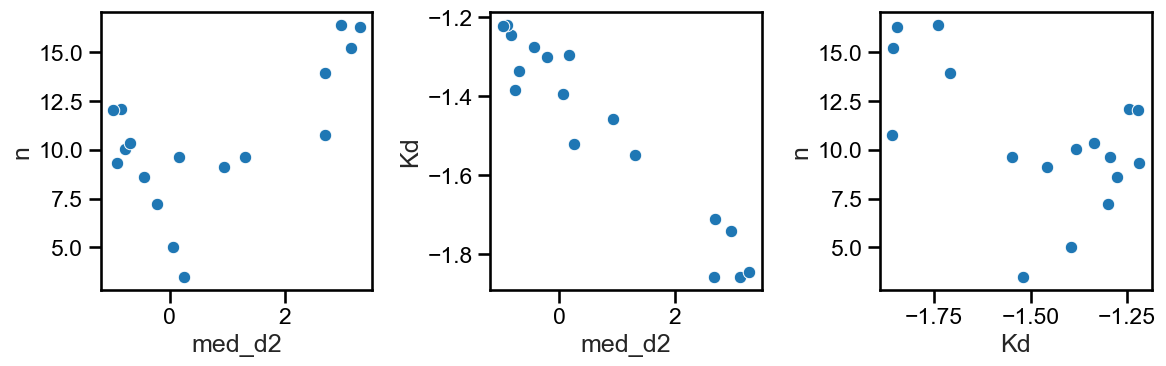

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

g = sns.scatterplot(data=adf, x="med_d2", y="n", ax=ax[0])
g = sns.scatterplot(data=adf, x="med_d2", y="Kd", ax=ax[1])
g = sns.scatterplot(data=adf, x="Kd", y="n", ax=ax[2])

plt.tight_layout()